In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.lines import Line2D
from matplotlib import colors as mcolors

import scanpy as sc
import squidpy as sq
import cellcharter as cc
import scvi

from pandas.api.types import is_numeric_dtype, is_categorical_dtype
from scipy.sparse import issparse

import sys
sys.path.append("/Users/christoffer/work/karolinska/development/MANA")
from utils import aggregate_neighbors_weighted, plot_spatial_compact_fast



# adding raw data to object

In [4]:
ad_sub = sc.read_h5ad('/Volumes/processing2/nature-dev-mouse-reanalysis/ad_all_processed_with_polygons.h5ad')

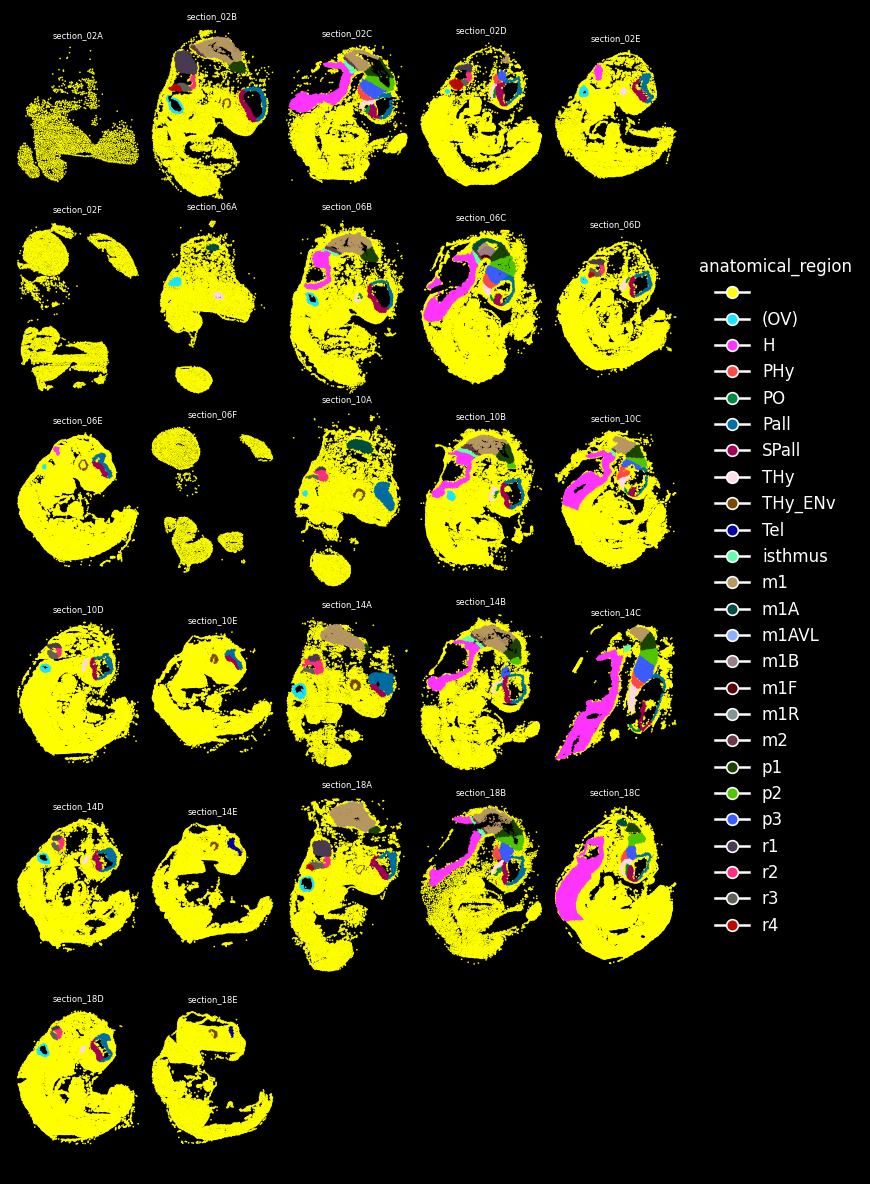

In [5]:
# usage
plot_spatial_compact_fast(
    ad_sub,
    color="anatomical_region",
    groupby="sample_id",
    spot_size=1,
    cols=5,
    height=10,
    legend_col_width=1.0,
    background="black",
    grey_alpha=0.05,
    #highlight=['4','5']
)

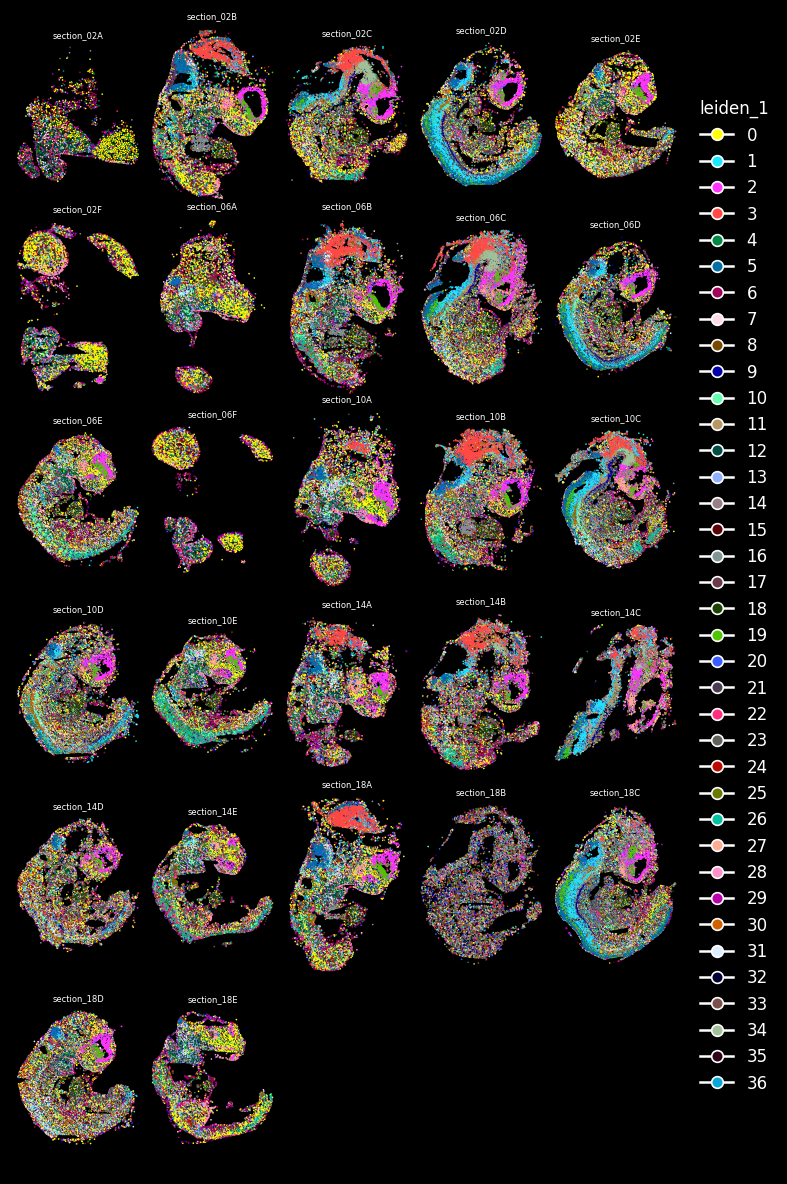

In [6]:
# usage
plot_spatial_compact_fast(
    ad_sub,
    color="leiden_1",
    groupby="sample_id",
    spot_size=1,
    cols=5,
    height=10,
    legend_col_width=1.0,
    background="black",
    grey_alpha=0.05,
    #highlight=['4','5']
)

In [7]:
# Ensure all layers are sparse CSR matrices
from scipy.sparse import csr_matrix, issparse

for name, layer in list(ad_sub.layers.items()):
    if not issparse(layer):
        ad_sub.layers[name] = csr_matrix(layer)

# Optional: verify
{k: type(v).__name__ for k, v in ad_sub.layers.items()}


{'counts': 'csr_matrix', 'normalized': 'csr_matrix'}

In [8]:
ad_sub

AnnData object with n_obs × n_vars = 321738 × 119
    obs: 'x', 'y', 'cluster', 'n_transcripts', 'density', 'elongation', 'area', 'avg_confidence', 'avg_assignment_confidence', 'max_cluster_frac', 'lifespan', 'section', 'sample_id', 'source_dir', 'n_genes_by_counts', 'total_counts', 'n_genes', 'leiden_0.5', 'leiden_1', 'leiden_2', 'anatomical_region'
    var: 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'hvg', 'leiden_0.5', 'leiden_0.5_colors', 'leiden_1', 'leiden_1_colors', 'leiden_2', 'leiden_2_colors', 'neighbors', 'pca', 'polygons_by_section', 'polygons_root', 'rank_genes_groups', 'umap', 'anatomical_region_colors'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    layers: 'counts', 'normalized'
    obsp: 'connectivities', 'distances'

In [9]:
scvi.model.SCVI.setup_anndata(
    ad_sub, 
    layer="counts", 
    batch_key='sample_id',
)

model = scvi.model.SCVI(ad_sub)

In [38]:
model.train(early_stopping=True, max_epochs = 500, enable_progress_bar=True)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores


Epoch 500/500: 100%|██████████| 500/500 [1:30:59<00:00, 10.88s/it, v_num=1, train_loss_step=57.9, train_loss_epoch=55.5]

`Trainer.fit` stopped: `max_epochs=500` reached.


Epoch 500/500: 100%|██████████| 500/500 [1:30:59<00:00, 10.92s/it, v_num=1, train_loss_step=57.9, train_loss_epoch=55.5]


In [39]:
ad_sub

AnnData object with n_obs × n_vars = 321738 × 119
    obs: 'x', 'y', 'cluster', 'n_transcripts', 'density', 'elongation', 'area', 'avg_confidence', 'avg_assignment_confidence', 'max_cluster_frac', 'lifespan', 'section', 'sample_id', 'source_dir', 'n_genes_by_counts', 'total_counts', 'n_genes', 'leiden_0.5', 'leiden_1', 'leiden_2', 'anatomical_region', '_scvi_batch', '_scvi_labels', 'leiden_mana_0.3', 'leiden_mana_1.0'
    var: 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'hvg', 'leiden_0.5', 'leiden_0.5_colors', 'leiden_1', 'leiden_1_colors', 'leiden_2', 'leiden_2_colors', 'neighbors', 'pca', 'polygons_by_section', 'polygons_root', 'rank_genes_groups', 'umap', 'anatomical_region_colors', '_scvi_uuid', '_scvi_manager_uuid', 'spatial_neighbors', 'X_mana_gauss_params', 'mana', 'leiden_mana_0.3', 'leiden_mana_1.0', 'leiden_mana_0.3_colors', 'l

In [40]:
# Get scVI latent representation
ad_sub.obsm['X_scVI'] = model.get_latent_representation()

print(f"Added X_scVI to ad_sub.obsm with shape: {ad_sub.obsm['X_scVI'].shape}")

Added X_scVI to ad_sub.obsm with shape: (321738, 10)


In [41]:
import squidpy as sq

# Build spatial graph
# This should be done per-sample to avoid creating edges between samples
sq.gr.spatial_neighbors(
    ad_sub,
    coord_type='generic',
    delaunay=True,  # Delaunay triangulation (connects nearby cells)
    key_added='spatial',
    library_key='sample_id'  # Ensure no edges between different samples,
)

print(f"Spatial graph built: {ad_sub.obsp['spatial_connectivities'].shape}")
print(f"Average neighbors per cell: {ad_sub.obsp['spatial_connectivities'].sum(axis=1).mean():.1f}")

Spatial graph built: (321738, 321738)
Average neighbors per cell: 6.0


In [42]:
import cellcharter as cc

In [43]:
cc.gr.remove_long_links(ad_sub)

In [44]:
# Run MANA with memory-efficient per-sample processing
# Adjust 'sample_key' to match your actual sample column name!

aggregate_neighbors_weighted(
    ad_sub,
    n_layers=3,              # Optimal balance (from MANA-5)
    aggregations='mean',     # Standard aggregation
    use_rep='X_scVI',        # Use scVI latent space
    out_key='X_mana_gauss',  # Output key
    hop_decay=0.2,           # Optimal decay (from MANA-4)
    distance_kernel='gaussian',  # Winner from MANA-6 benchmark
    spatial_key='spatial',
    normalize_weights=True,
    include_self=True,
    sample_key='sample_id',  # CRITICAL: Process per-sample to avoid memory issues!
)

print("\nMANA aggregation complete!")
print(f"Output stored in adata.obsm['X_mana_gauss'] with shape: {ad_sub.obsm['X_mana_gauss'].shape}")

Processing 27 samples separately for memory efficiency...
  Processing sample 1/27: section_02A (2,289 cells)
  Processing sample 2/27: section_02B (10,244 cells)
  Processing sample 3/27: section_02C (11,990 cells)
  Processing sample 4/27: section_02D (13,528 cells)
  Processing sample 5/27: section_02E (10,592 cells)
  Processing sample 6/27: section_02F (5,094 cells)
  Processing sample 7/27: section_06A (6,443 cells)
  Processing sample 8/27: section_06B (13,286 cells)
  Processing sample 9/27: section_06C (20,417 cells)
  Processing sample 10/27: section_06D (15,270 cells)
  Processing sample 11/27: section_06E (15,067 cells)
  Processing sample 12/27: section_06F (2,723 cells)
  Processing sample 13/27: section_10A (8,795 cells)
  Processing sample 14/27: section_10B (15,563 cells)
  Processing sample 15/27: section_10C (19,569 cells)
  Processing sample 16/27: section_10D (18,529 cells)
  Processing sample 17/27: section_10E (11,863 cells)
  Processing sample 18/27: section_14A

In [45]:
# Build neighborhood graph in MANA feature space
sc.pp.neighbors(
    ad_sub,
    use_rep='X_mana_gauss',
    n_neighbors=15,
    key_added='mana'
)

print("Neighbor graph built in MANA feature space")

Neighbor graph built in MANA feature space


In [46]:
resolutions = [0.3, 0.5, 0.8, 1.0, 1.5,2]

In [47]:
list_ = []
for res in resolutions: 
    key_added=f'leiden_mana_{res}'
    print(key_added)
    list_.append(key_added)

leiden_mana_0.3
leiden_mana_0.5
leiden_mana_0.8
leiden_mana_1.0
leiden_mana_1.5
leiden_mana_2


In [48]:
list_

['leiden_mana_0.3',
 'leiden_mana_0.5',
 'leiden_mana_0.8',
 'leiden_mana_1.0',
 'leiden_mana_1.5',
 'leiden_mana_2']

In [49]:
# Leiden clustering
# Try a few resolutions to see what works best
resolutions = [0.3, 0.5, 0.8, 1.0, 1.5,2]

for res in resolutions:
    sc.tl.leiden(
        ad_sub,
        resolution=res,
        key_added=f'leiden_mana_{res}',
        neighbors_key='mana'
    )
    n_clusters = ad_sub.obs[f'leiden_mana_{res}'].nunique()
    print(f"Resolution {res}: {n_clusters} clusters")

Resolution 0.3: 14 clusters
Resolution 0.5: 19 clusters
Resolution 0.8: 28 clusters
Resolution 1.0: 31 clusters
Resolution 1.5: 45 clusters
Resolution 2: 53 clusters


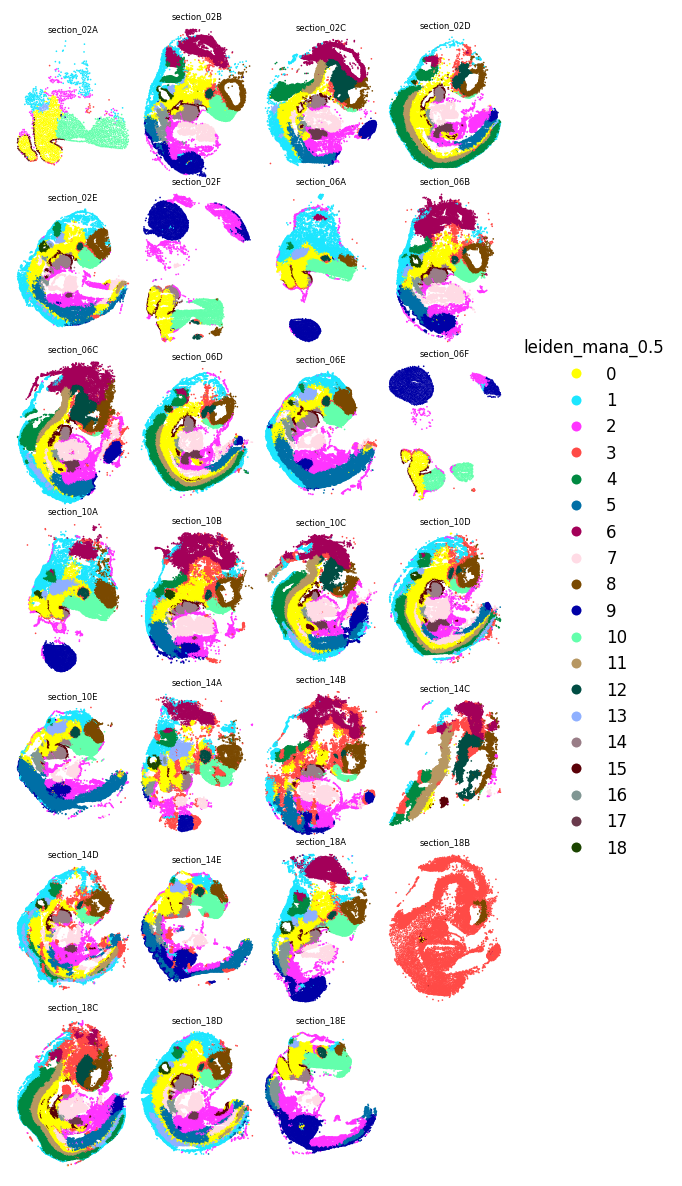

In [50]:
# Visualize MANA clustering (resolution 0.5 as starting point)
plot_spatial_compact_fast(
    ad_sub, 
    color='leiden_mana_0.5',
    groupby='sample_id',  # Adjust to your actual sample column
    spot_size = 1,
    cols=4,
    height=10,
    background='white',
    dpi=120,
   
)

In [55]:
del ad_sub.uns['leiden_mana_1.0_colors']

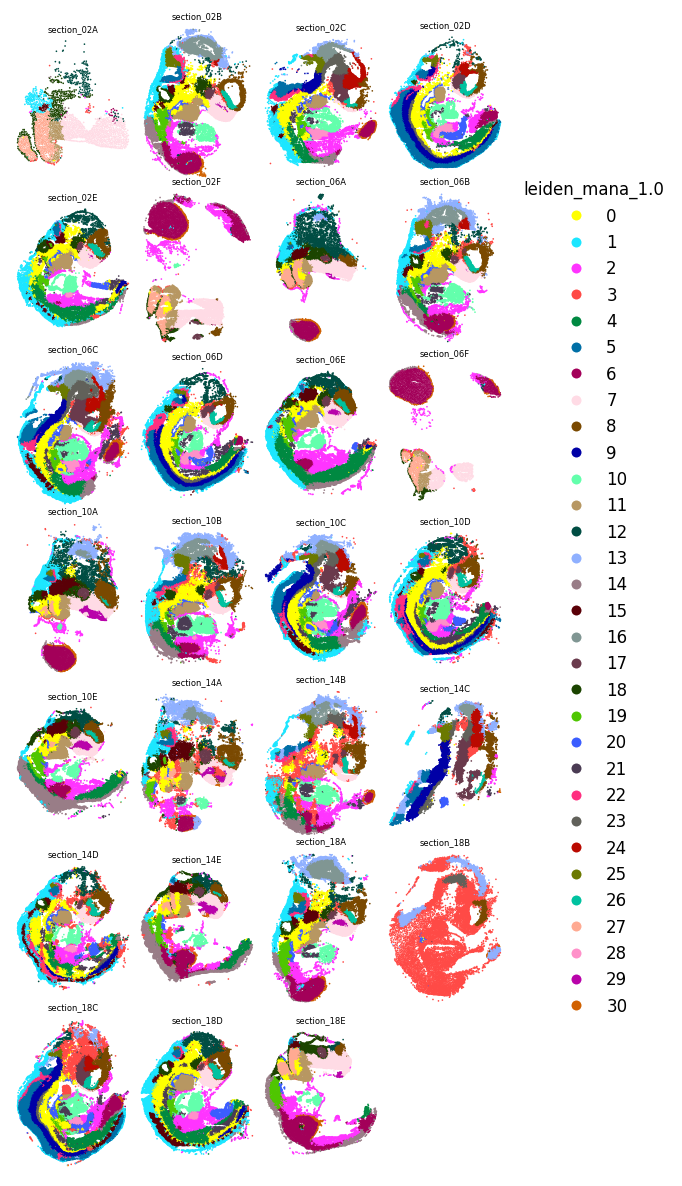

In [56]:
# Visualize MANA clustering (resolution 0.5 as starting point)
plot_spatial_compact_fast(
    ad_sub, 
    color='leiden_mana_1.0',
    groupby='sample_id',  # Adjust to your actual sample column
    spot_size = 1,
    cols=4,
    height=10,
    background='white',
    dpi=120,
   
)

In [57]:
sc.pp.highly_variable_genes(ad_sub,layer='normalized', n_top_genes=50, flavor='seurat_v3')


In [58]:
ad_sub.X = ad_sub.layers['normalized'].copy()

In [59]:
ad_sub.write('/Volumes/processing2/nature-dev-mouse-reanalysis/ad_all_processed_with_polygons_mana_2.h5ad')

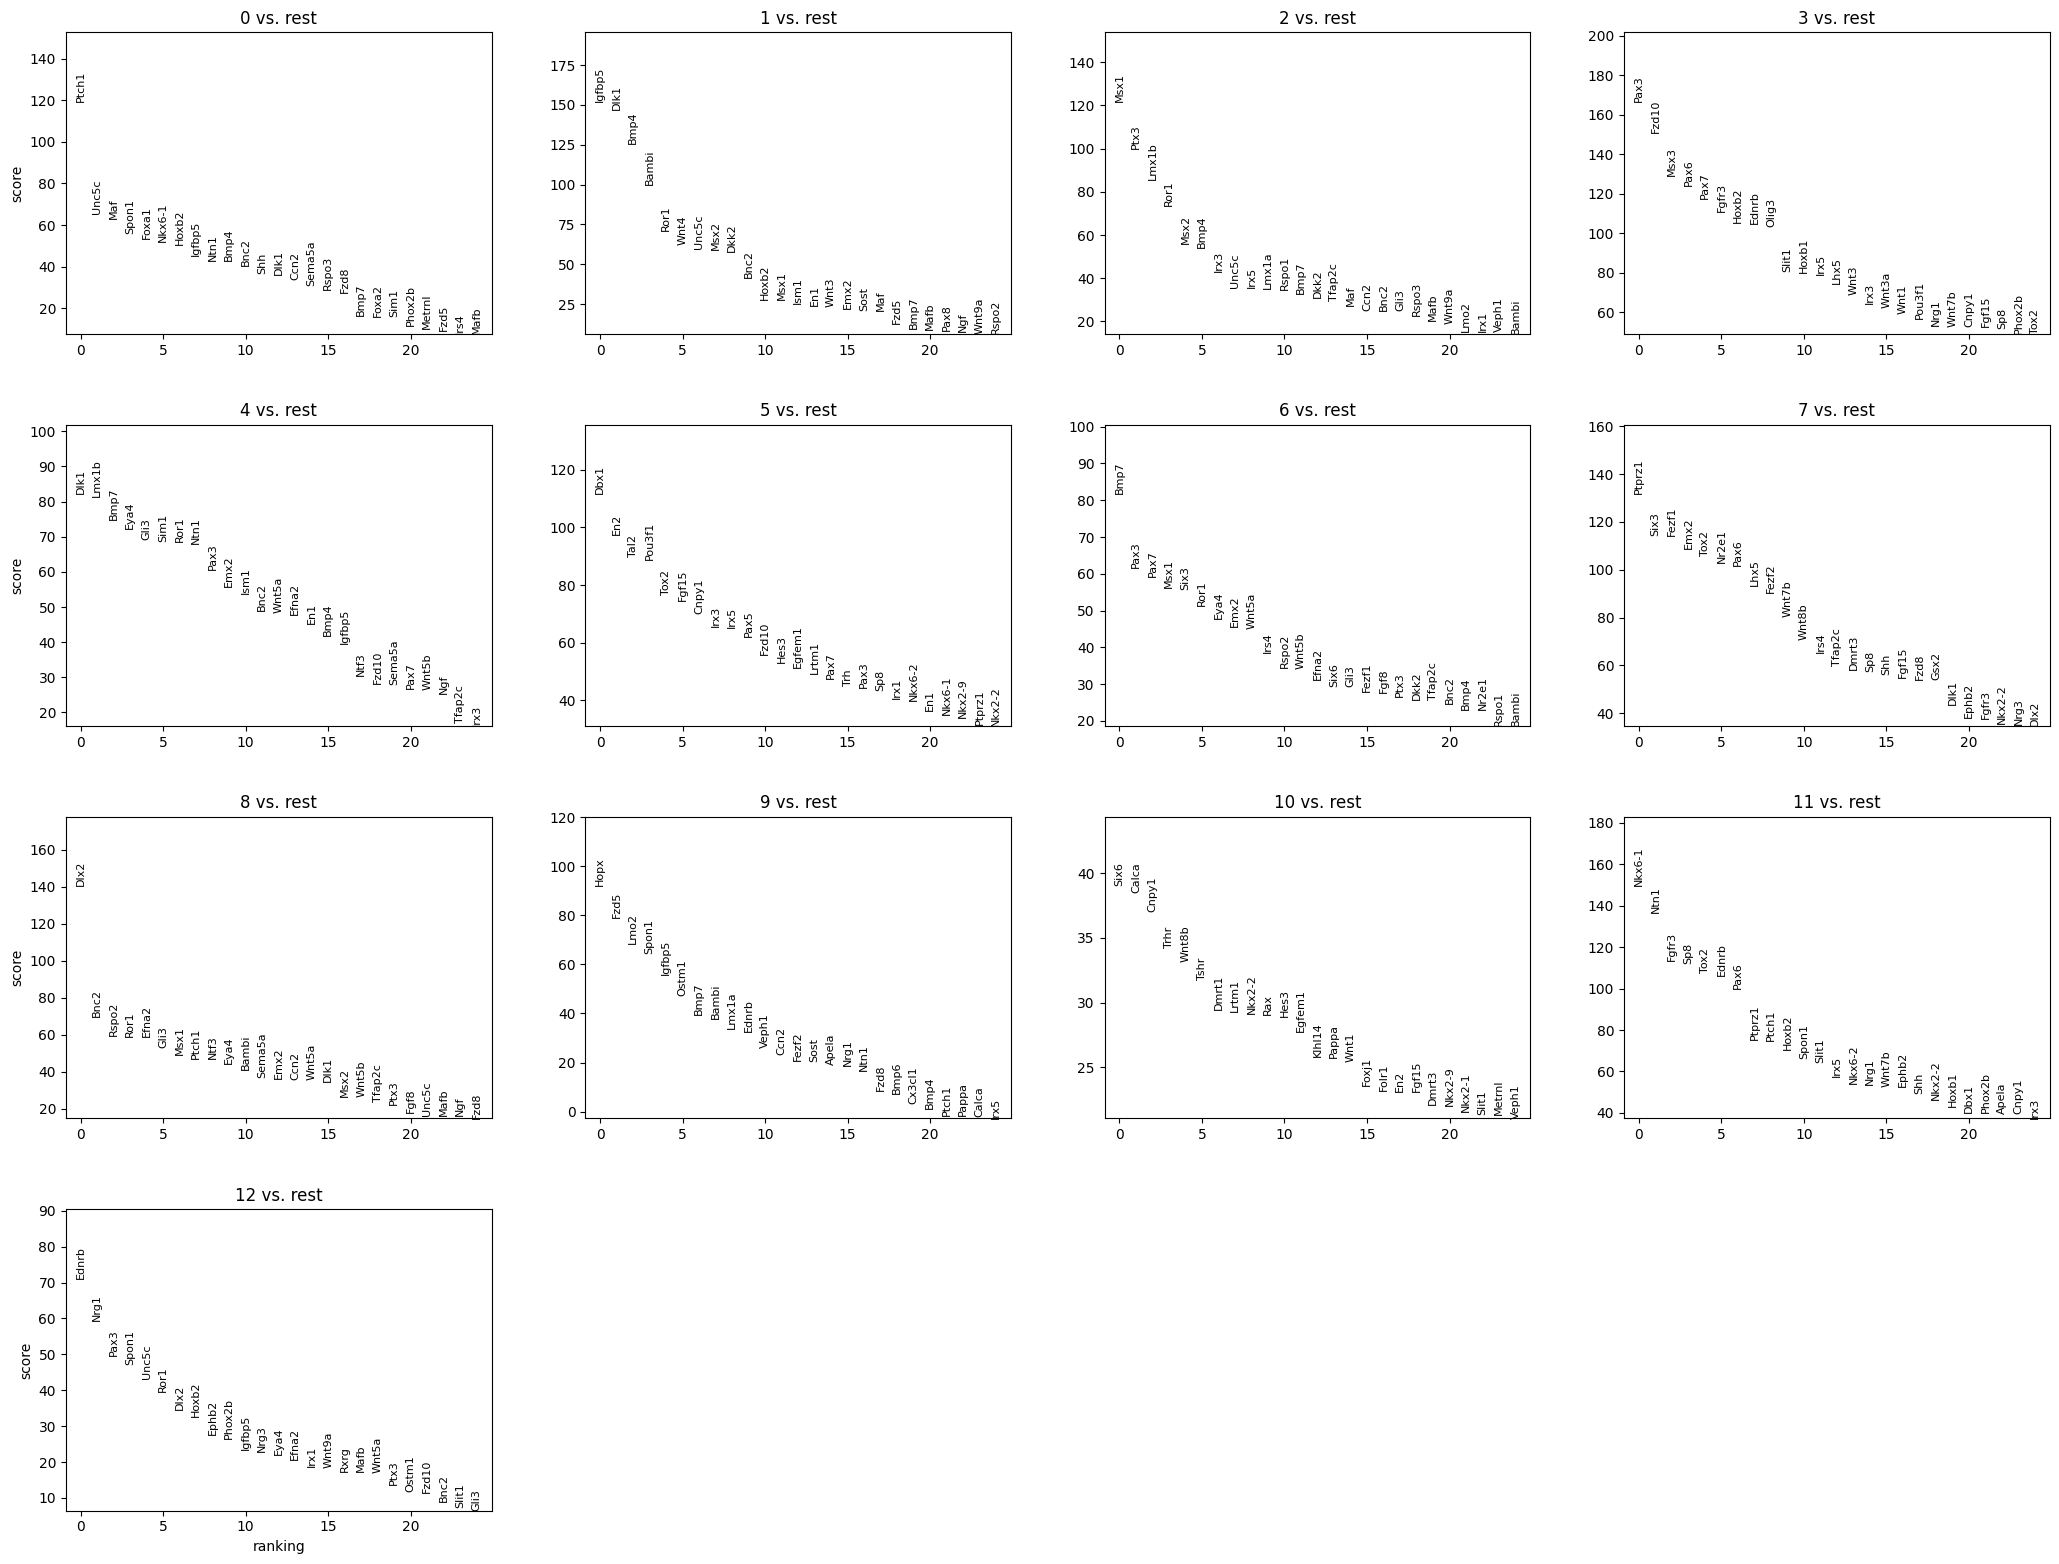

0
Ptch1 Unc5c Maf Spon1 Foxa1 Nkx6-1 Hoxb2 Igfbp5 Ntn1 Bmp4 Bnc2 Shh Dlk1 Ccn2 Sema5a Rspo3 Fzd8 Bmp7 Foxa2 Sim1 Phox2b Metrnl Fzd5 Irs4 Mafb Lmo2 Rspo2 Ror1 Sost Stum
 
1
Igfbp5 Dlk1 Bmp4 Bambi Ror1 Wnt4 Unc5c Msx2 Dkk2 Bnc2 Hoxb2 Msx1 Ism1 En1 Wnt3 Emx2 Sost Maf Fzd5 Bmp7 Mafb Pax8 Ngf Wnt9a Rspo2 Apela Ntf3 Rspo1 Lmo2 Sema5a
 
2
Msx1 Ptx3 Lmx1b Ror1 Msx2 Bmp4 Irx3 Unc5c Irx5 Lmx1a Rspo1 Bmp7 Dkk2 Tfap2c Maf Ccn2 Bnc2 Gli3 Rspo3 Mafb Wnt9a Lmo2 Irx1 Veph1 Bambi Fzd10 Rxrg Metrnl Dmrt3 Pappa
 
3
Pax3 Fzd10 Msx3 Pax6 Pax7 Fgfr3 Hoxb2 Ednrb Olig3 Slit1 Hoxb1 Irx5 Lhx5 Wnt3 Irx3 Wnt3a Wnt1 Pou3f1 Nrg1 Wnt7b Cnpy1 Fgf15 Sp8 Phox2b Tox2 Irx1 Wnt4 Pax8 Ptprz1 Ephb2
 
4
Dlk1 Lmx1b Bmp7 Eya4 Gli3 Sim1 Ror1 Ntn1 Pax3 Emx2 Ism1 Bnc2 Wnt5a Efna2 En1 Bmp4 Igfbp5 Ntf3 Fzd10 Sema5a Pax7 Wnt5b Ngf Tfap2c Irx3 Fgf8 Dkk2 Slit1 Rxrg Rspo3
 
5
Dbx1 En2 Tal2 Pou3f1 Tox2 Fgf15 Cnpy1 Irx3 Irx5 Pax5 Fzd10 Hes3 Egfem1 Lrtm1 Pax7 Trh Pax3 Sp8 Irx1 Nkx6-2 En1 Nkx6-1 Nkx2-9 Ptprz1 Nkx2-2 Fgf17 Bmp6 Wnt1 Pax6 Fo

In [36]:
import pandas as pd
key = "leiden_mana_0.3"              # <-- change to your cluster column

sc.tl.rank_genes_groups(
    ad_sub,
    groupby=key,
    reference="rest",             # each group vs all other cells
    method="t-test",
    pts=True,                     # add fraction expressing
)
sc.pl.rank_genes_groups(ad_sub, n_genes=25, sharey=False)

marker_genes = pd.DataFrame({
    group: ad_sub.uns['rank_genes_groups']['names'][group][:30]
    for group in ad_sub.uns['rank_genes_groups']['names'].dtype.names
})
for col in marker_genes.columns: 
    print(col)
    genes = marker_genes[col].tolist()

    print(" ".join(genes))
    print(' ')